In [2]:
import random, os, dlib, tqdm, glob, cv2, warnings, time, gc
from keras.utils import np_utils, generic_utils
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.callbacks import ModelCheckpoint
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout, Flatten, Dense, BatchNormalization
from keras.models import Sequential
from keras import backend as K
from scipy import misc, ndimage
from sklearn.datasets import load_files
from PIL import ImageFile
from urllib.request import urlretrieve
from extract_bottleneck_features import *
import numpy as np
from IPython.core.display import display, HTML
import matplotlib.pyplot as plt
warnings.simplefilter(action='ignore', category=DeprecationWarning)
%matplotlib inline
display(HTML("<style>.container {width:90% !important; }</style>"))
random.seed(8675309)

- Download dog and human images
- Download VGG16 and Xception bottleneck features for transfer learning
- Install dlib for human face detector

In [2]:
# urlretrieve('https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip')
# urlretrieve('https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip')
# !unzip dogImages.zip
# !dogImages.zip
# !unzip lfw.zip
# !rm lfw.zip
# !mkdir bottleneck_features
# urlretrieve('https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG16Data.npz', 'bottleneck_features/DogVGG16Data.npz')
# urlretrieve('https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogXceptionData.npz', 'bottleneck_features/DogXceptionData.npz')
# !python3 -m pip install dlib

## Load

In [3]:
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

train_files, train_targets = load_dataset('dogImages/train')
valid_files, valid_targets = load_dataset('dogImages/valid')
test_files, test_targets = load_dataset('dogImages/test')

dog_names = [item[20:-1] for item in sorted(glob.glob('dogImages/train/*/'))]

print('There are {} total dog categories.'.format(len(dog_names)))
print('There are {} total dog images.'.format(len(np.hstack([train_files, valid_files, test_files]))))
print('-'*50)
print('There are {} training dog images.'.format(len(train_files)))
print('There are {} validation dog images.'.format(len(valid_files)))
print('There are {} test dog images.'.format(len(test_files)))

human_files = np.array(glob.glob('lfw/*/*'))
random.shuffle(human_files)
print('There are {} total human images.'.format(len(human_files)))

There are 133 total dog categories.
There are 8351 total dog images.
--------------------------------------------------
There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.
There are 13233 total human images.


## Human face detector

In [4]:
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

In [5]:
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

In [6]:
def face_detector2(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    detector = dlib.get_frontal_face_detector()
    faces1 = detector(gray, 0)
    faces2 = face_cascade.detectMultiScale(gray)
    if len(faces1) > 0 and len(faces2) > 0:
        return True
    else:
        return False

In [7]:
def percentage_predicted(img_file, detector):
    return 100.0*([detector(i) for i in img_file].count(True))/len(img_file)

In [8]:
print('Using the original face_detector:')
print('{:.2f}% of the first 1000 images in human_files have a detected human face.'.\
      format(percentage_predicted(human_files[:1000], face_detector)))
print('{:.2f}% of the first 1000 images in train_files have a detected human face.'.\
      format(percentage_predicted(train_files[:1000], face_detector)))

print('Using the new face_detector2:')
print('{:.2f}% of the first 1000 images in human_files have a detected human face.'.\
      format(percentage_predicted(human_files[:1000], face_detector2)))
print('{:.2f}% of the first 1000 images in train_files have a detected human face.'.\
      format(percentage_predicted(train_files[:1000], face_detector2)))

Using the original face_detector:
99.50% of the first 1000 images in human_files have a detected human face.
11.60% of the first 1000 images in train_files have a detected human face.
Using the new face_detector2:
99.30% of the first 1000 images in human_files have a detected human face.
3.30% of the first 1000 images in train_files have a detected human face.


In [9]:
def plot_face_detect(img_files, detector, faces=True):
    k = 0
    image_path = list()
    for i in img_files:
        if detector(i) == faces:
            image_path += [i]
    fig = plt.figure(figsize=(25,25))
    for j in image_path:
        fig.add_subplot(6, 6, k+1)
        plt.imshow(np.expand_dims(ndimage.imread(j), 0)[0])
        plt.title(j.split('/')[-1])
        k += 1
    plt.show()  

In the first 200 human images, the following image(s) failed to detect a human face


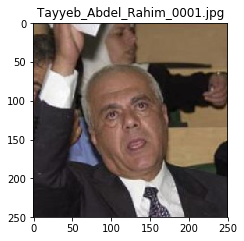

In [13]:
print('In the first 200 human images, the following image(s) failed to detect a human face')
plot_face_detect(human_files[:200], face_detector2, faces=False)

In the first 200 dog images, the following image(s) are detected a human face


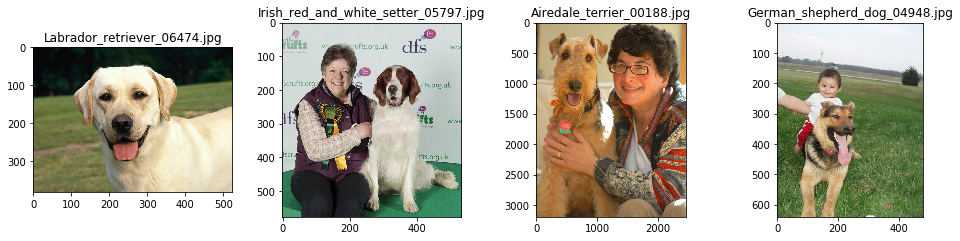

In [14]:
print('In the first 200 dog images, the following image(s) are detected a human face')
plot_face_detect(train_files[:200], face_detector2, faces=True)

## Dog detector

In [15]:
ResNet50_model = ResNet50(weights='imagenet')

In [16]:
def path_to_tensor(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    return np.expand_dims(x, axis=0)
def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm.tqdm(img_paths)]
    return np.vstack(list_of_tensors)
def ResNet50_predict_labels(img_path):
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

In [17]:
print('{:.2f}% of the first 1000 images in human_files have a detected dog.'.format(
    percentage_predicted(human_files[:1000], dog_detector)))
print('{:.2f}% of the first 1000 images in dog_files have a detected dog.'.format(
    percentage_predicted(train_files[:1000], dog_detector)))

1.20% of the first 1000 images in human_files have a detected dog.
98.40% of the first 1000 images in dog_files have a detected dog.


## Classify Dog Breeds (from Scratch)

In [18]:
ImageFile.LOAD_TRUNCATED_IMAGES = True
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 836/836 [00:14<00:00, 59.05it/s]


### Model Architecture

In [19]:
def swish(x):
    return (K.sigmoid(x) * x)
generic_utils.get_custom_objects().update({'swish': swish})

model = Sequential()
model.add(Conv2D(32, kernel_size=(5), activation='swish', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization(momentum=0.75, epsilon=0.001))
model.add(Conv2D(64, kernel_size=(4), activation='swish'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization(momentum=0.75, epsilon=0.001))
model.add(Conv2D(128, kernel_size=(3), activation='swish'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization(momentum=0.75, epsilon=0.001))
model.add(Conv2D(256, kernel_size=(2), activation='swish'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization(momentum=0.75, epsilon=0.001))
model.add(GlobalAveragePooling2D())
model.add(Dense(133, activation='softmax'))
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 220, 220, 32)      2432      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 110, 110, 32)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 110, 110, 32)      128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 107, 107, 64)      32832     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 53, 53, 64)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 53, 53, 64)        256       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 51, 51, 128)       73856     
__________

### Compile the Model

In [ ]:
model.compile(optimizer=Adam(lr=2e-3), loss='categorical_crossentropy', metrics=['accuracy'])

### Train the Model

In [ ]:
epochs = 20
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch_withdropout.hdf5', verbose=1, save_best_only=True)
hist = model.fit(train_tensors, train_targets, validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

### Load the Model with the Best Validation Loss

In [ ]:
model.load_weights('saved_models/weights.best.from_scratch_withdropout.hdf5')

### Test the Model

In [ ]:
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: {:.4f}%'.format(test_accuracy))

In [20]:
def plot_model(model_details):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    axs[0].plot(range(1,len(model_details.history['acc'])+1),model_details.history['acc'])
    axs[0].plot(range(1,len(model_details.history['val_acc'])+1),model_details.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_details.history['acc'])+1),len(model_details.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    axs[1].plot(range(1,len(model_details.history['loss'])+1),model_details.history['loss'])
    axs[1].plot(range(1,len(model_details.history['val_loss'])+1),model_details.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_details.history['loss'])+1),len(model_details.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

### Plot the model

In [ ]:
plot_model(hist)

## Create a CNN to Classify Dog Breeds (using Transfer Learning, VGG16)

In [21]:
bottleneck_features = np.load('bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

### Model Architecture

In [22]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))
print(VGG16_model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 133)               68229     
Total params: 68,229
Trainable params: 68,229
Non-trainable params: 0
_________________________________________________________________
None


### Compile the Model

In [23]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

In [24]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', verbose=False, save_best_only=True)
hist_VGG16 = VGG16_model.fit(train_VGG16, train_targets, validation_data=(valid_VGG16, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 2s 260us/step - loss: 12.1271 - acc: 0.1229 - val_loss: 10.5290 - val_acc: 0.2180
Epoch 2/20
6680/6680 [==============================] - 1s 127us/step - loss: 9.4254 - acc: 0.3003 - val_loss: 9.2910 - val_acc: 0.3114
Epoch 3/20
6680/6680 [==============================] - 1s 124us/step - loss: 8.5891 - acc: 0.3933 - val_loss: 8.7717 - val_acc: 0.3509
Epoch 4/20
6680/6680 [==============================] - 1s 125us/step - loss: 8.0092 - acc: 0.4398 - val_loss: 8.4807 - val_acc: 0.3856
Epoch 5/20
6680/6680 [==============================] - 1s 126us/step - loss: 7.7693 - acc: 0.4726 - val_loss: 8.3721 - val_acc: 0.4036
Epoch 6/20
6680/6680 [==============================] - 1s 126us/step - loss: 7.5454 - acc: 0.4885 - val_loss: 8.2502 - val_acc: 0.4000
Epoch 7/20
6680/6680 [==============================] - 1s 122us/step - loss: 7.3314 - acc: 0.5094 - val_loss: 8.0200 - val_acc: 0.4180

### Load the Model with the Best Validation Loss

In [25]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

### Test the Model

In [26]:
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: {:.4f}%'.format(test_accuracy))

Test accuracy: 51.1962%


### Plot the Model

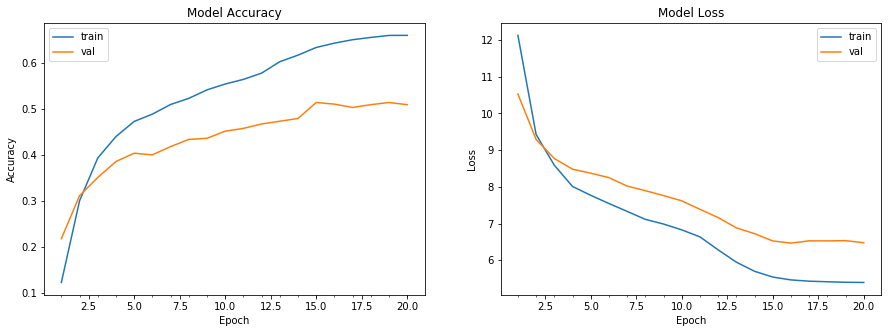

In [27]:
plot_model(hist_VGG16)

## Create a CNN to Classify Dog Breeds (using Transfer Learning, Xception)

In [28]:
bottleneck_features = np.load('bottleneck_features/DogXceptionData.npz')
train_Xception = bottleneck_features['train']
valid_Xception = bottleneck_features['valid']
test_Xception = bottleneck_features['test']

### Model Architecture

In [29]:
Xception_model = Sequential()
Xception_model.add(GlobalAveragePooling2D(input_shape=train_Xception.shape[1:]))
Xception_model.add(Dense(133, activation = 'softmax'))
print(Xception_model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 133)               272517    
Total params: 272,517
Trainable params: 272,517
Non-trainable params: 0
_________________________________________________________________
None


### Compile the Model

In [30]:
Xception_model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=8e-5), metrics=['accuracy'])

### Train the Model

In [31]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.Xception.hdf5', verbose=False, save_best_only=True)
hist_Xception = Xception_model.fit(train_Xception, train_targets, validation_data=(valid_Xception, valid_targets),
          epochs=30, batch_size=50, callbacks=[checkpointer], verbose=False, shuffle=True)

### Load the Model with the Best Validation Loss

In [32]:
Xception_model.load_weights('saved_models/weights.best.Xception.hdf5')

### Test the Model

In [33]:
Xception_predictions = [np.argmax(Xception_model.predict(np.expand_dims(feature, axis=0))) for feature in test_Xception]
test_accuracy = 100*np.sum(np.array(Xception_predictions)==np.argmax(test_targets, axis=1))/len(Xception_predictions)
print('Test accuracy: {:.4f}%'.format(test_accuracy))

Test accuracy: 85.6459%


### Plot the Model

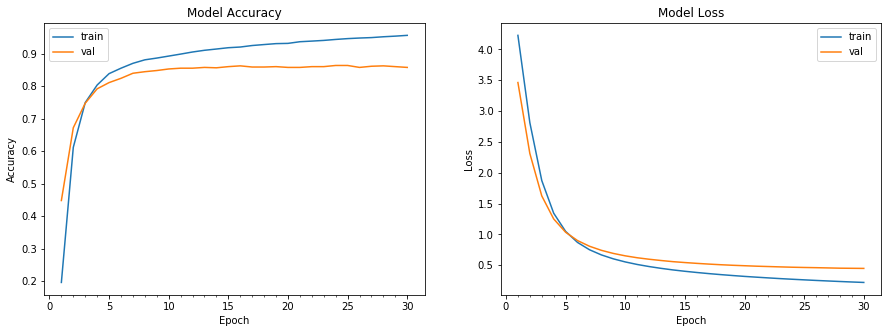

In [34]:
plot_model(hist_Xception)

## Fun fact

In [35]:
def Xception_predict_breed(img_path):
    bottleneck_feature = extract_Xception(path_to_tensor(img_path))
    predicted_vector = Xception_model.predict(bottleneck_feature)
    return dog_names[np.argmax(predicted_vector)]

In [39]:
def plot_results(file_paths):
    rows = len(file_paths)
    k = 0
    for i in file_paths:
        dog_breed = Xception_predict_breed(i)
        for root, dirs, files in os.walk('dogImages/train/'):
            if dog_breed in root:
                family = root + '/' + files[0]
                break
        fig = plt.figure(figsize=(20,30))
        k += 1
        fig.add_subplot(rows, 3, k)
        plt.imshow(np.expand_dims(ndimage.imread(i), 0)[0])
        if face_detector2(i):
            plt.title('Hi Human! Your dog breed is {}'.format(dog_breed), fontdict={'fontsize':20})
            k += 1
            fig.add_subplot(rows, 3, k)
            plt.imshow(np.expand_dims(ndimage.imread('test_images/arrow.png'), 0)[0])  
            plt.axis('off')
            k += 1
            fig.add_subplot(rows, 3, k)
            plt.imshow(np.expand_dims(ndimage.imread(family), 0)[0])
            plt.title('This is your family!', fontdict={'fontsize':20})
        elif dog_detector(i):
            plt.title('Hi Dog! I guess your breed is {}'.format(dog_breed), fontdict={'fontsize':20})
            k += 1
            fig.add_subplot(rows, 3, k)
            plt.imshow(np.expand_dims(ndimage.imread('test_images/arrow.png'), 0)[0])
            plt.axis('off')
            k += 1
            fig.add_subplot(rows, 3, k)
            plt.imshow(np.expand_dims(ndimage.imread(family), 0)[0])
            plt.title('This is your family!', fontdict={'fontsize':20})
        else:
            plt.title('You are neither human nor dog!', fontdict={'fontsize':20})
    plt.show() 

In [41]:
!mkdir test_images
urlretrieve('https://cdn.pixabay.com/photo/2017/04/06/09/16/arrow-2207748_960_720.png', 'test_images/arrow.png')
urlretrieve('https://cdn.pixabay.com/photo/2018/04/27/16/49/dog-3355192_960_720.jpg', 'test_images/Boxer.jpg')
urlretrieve('https://cdn.pixabay.com/photo/2014/11/14/05/27/yellow-530245_1280.jpg', 'test_images/Labrador_retriever.jpg')
urlretrieve('https://cdn.pixabay.com/photo/2018/08/20/14/08/dog-3619020_1280.jpg', 'test_images/Pomeranian.jpg')
urlretrieve('https://cdn.pixabay.com/photo/2018/03/27/21/50/nature-3267539_960_720.jpg', 'test_images/Golden_retriever.jpg')
urlretrieve('https://cdn.pixabay.com/photo/2018/02/21/15/06/woman-3170568_960_720.jpg', 'test_images/woman.jpg')
urlretrieve('https://cdn.pixabay.com/photo/2017/06/28/04/29/adult-2449725_960_720.jpg', 'test_images/man.jpg')

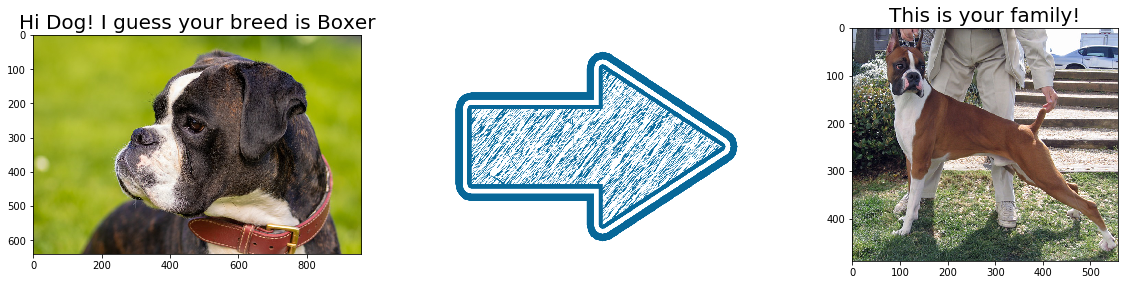

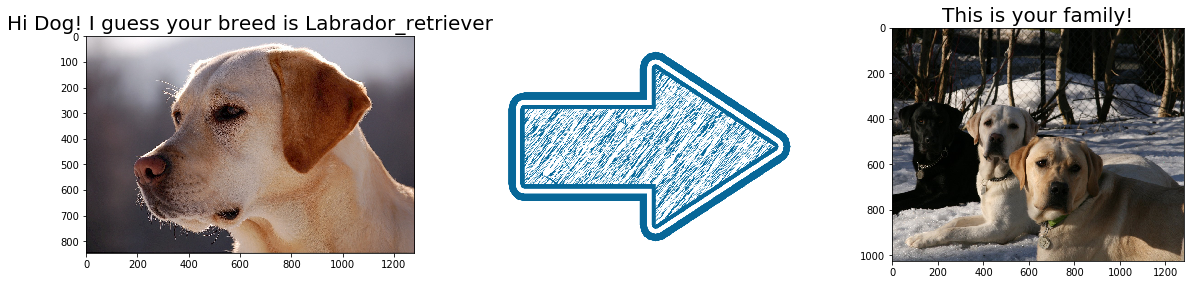

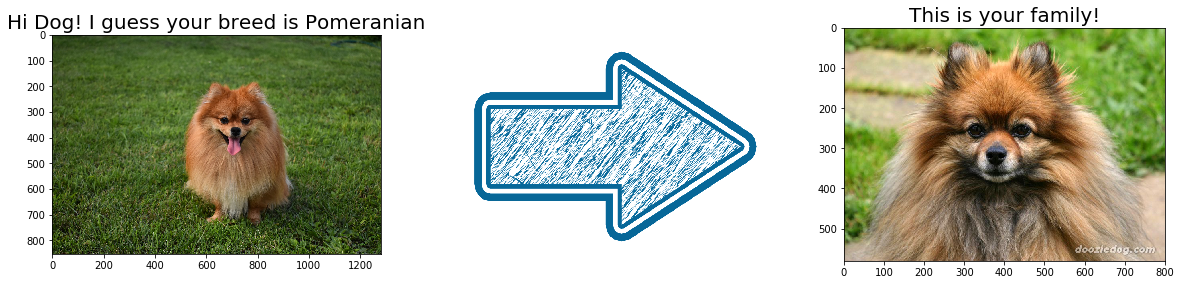

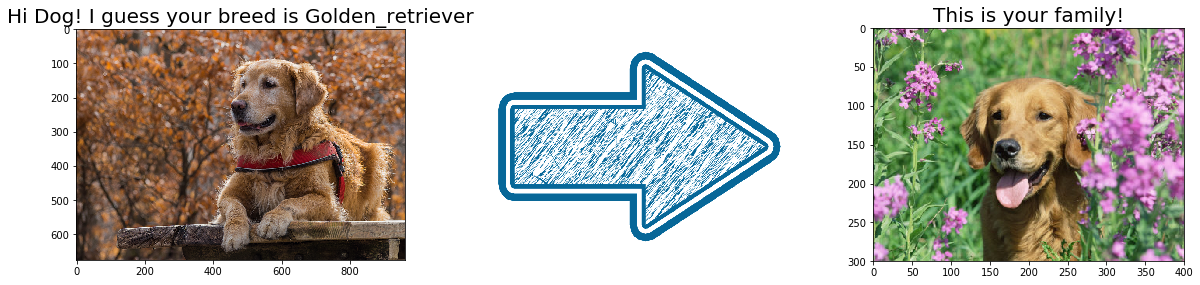

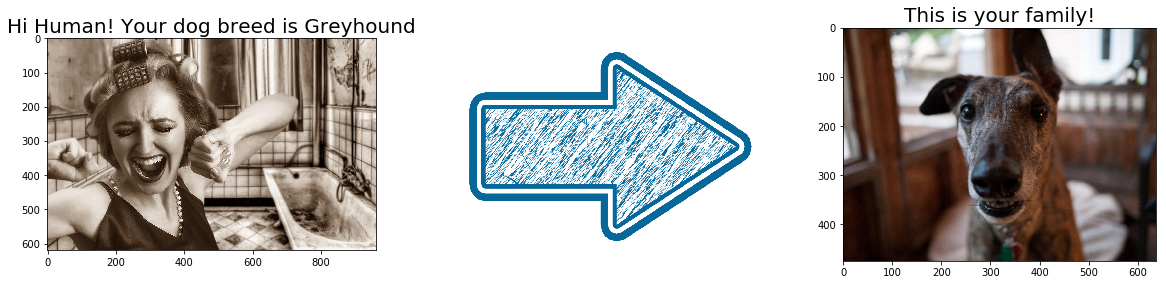

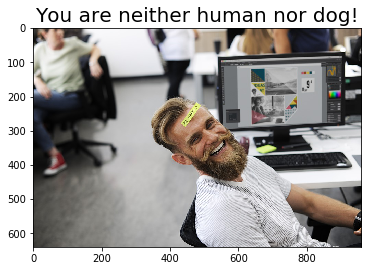

In [42]:
file_paths = ['test_images/Boxer.jpg',
              'test_images/Labrador_retriever.jpg',
              'test_images/Pomeranian.jpg',
              'test_images/Golden_retriever.jpg', 
              'test_images/woman.jpg',
              'test_images/man.jpg']
plot_results(file_paths)